# 指数增强策略
### 1、沪深300指数增强
### 2、中证500指数增强
### 3、中证1000指数增强

In [1]:
import sys
sys.path.append('..')

import warnings
import pandas as pd
from QHData.query import Query
from secuntial import Sequential
from QHFactor.transformer import Load_X_y
from QHData.data_load import DataLoader,CodesLoader
from sklearn.model_selection import train_test_split

from estimator import LGBMRollingRegressor
from features_selector import LGBMFeatureSelector

warnings.filterwarnings('ignore')


No module named 'wtpy'
Error importing QUANTAXIS module: No module named 'QUANTAXIS'


In [34]:
# 1、加载数据

seq = Sequential('EXP_ENH300_1M')
data_loader = DataLoader(start_date='2015-01-01',end_date='2025-03-01',freq='monthly')

code_loader = CodesLoader()
code_zz500 = code_loader.load_stk_codes('zz500.json')   #中证500
code_hs300 = code_loader.load_stk_codes('hs300.json')   #沪深300
stk_data = data_loader.load_stock(codes=code_hs300)   # 加载成分股数据

# # 数据过滤
stk_data = stk_data.groupby(level=1).filter(lambda x:len(x) > 12)  # 过滤掉上市小于1年的股票
# stk_data.dropna(subset=['open','close'],axis=0,inplace=True)        # 删除为空的数据
stk_data = stk_data.groupby(level=1,group_keys=False).apply(lambda x:x.fillna(method='ffill'))

# 加载市场基准
bench_market_data = data_loader.load_bench_market('000300',freq='M')    

# # 计算超额收益
exc_returns = stk_data.close.unstack().pct_change(periods=1).apply(lambda x:x - bench_market_data.close.pct_change(periods=1)).shift(-1).stack().droplevel(1)


[2025-03-12 14:30:34 - INFO] Model name: EXP_ENH300_1M
[2025-03-12 14:30:34 - INFO] Training started at 2025-03-12 14:30:34


In [35]:
# 2.计算因子数据
factors = seq.calculate_factors(dataset=stk_data,window=12)

[2025-03-12 14:35:56 - INFO] # 2. calculate factors
[2025-03-12 14:35:56 - INFO] Factor calculation and processing started
Processing stocks: 100%|██████████| 300/300 [00:04<00:00, 67.73it/s]
[2025-03-12 14:36:09 - INFO] Factors calculated.
[2025-03-12 14:36:09 - INFO] Factors shape: (32284, 171)
[2025-03-12 14:36:09 - INFO] Number of factors: 171
[2025-03-12 14:36:09 - INFO] Factor types: {'alpha_001': dtype('float32'), 'alpha_002': dtype('float32'), 'alpha_003': dtype('float32'), 'alpha_004': dtype('float32'), 'alpha_005': dtype('float32'), 'alpha_006': dtype('float32'), 'alpha_007': dtype('float32'), 'alpha_008': dtype('float32'), 'alpha_009': dtype('float32'), 'alpha_010': dtype('float32'), 'alpha_011': dtype('float32'), 'alpha_012': dtype('float32'), 'alpha_013': dtype('float32'), 'alpha_014': dtype('float32'), 'alpha_015': dtype('float32'), 'alpha_016': dtype('float32'), 'alpha_017': dtype('float32'), 'alpha_018': dtype('float32'), 'alpha_019': dtype('float32'), 'alpha_020': dtyp

[2025-03-12 14:36:12 - INFO] # 3. Selecting features
[2025-03-12 14:36:12 - INFO] Transforming X and y...
[2025-03-12 14:36:12 - INFO] Transformation completed.
[2025-03-12 14:36:12 - INFO] Applying feature selection...
[2025-03-12 14:36:20 - INFO] Feature selection completed.
[2025-03-12 14:36:20 - INFO] Selected features shape: (28785, 20)
[2025-03-12 14:36:20 - INFO] Plotting correlation of selected features...
[2025-03-12 14:36:20 - INFO] Plotting feature correlation matrix...


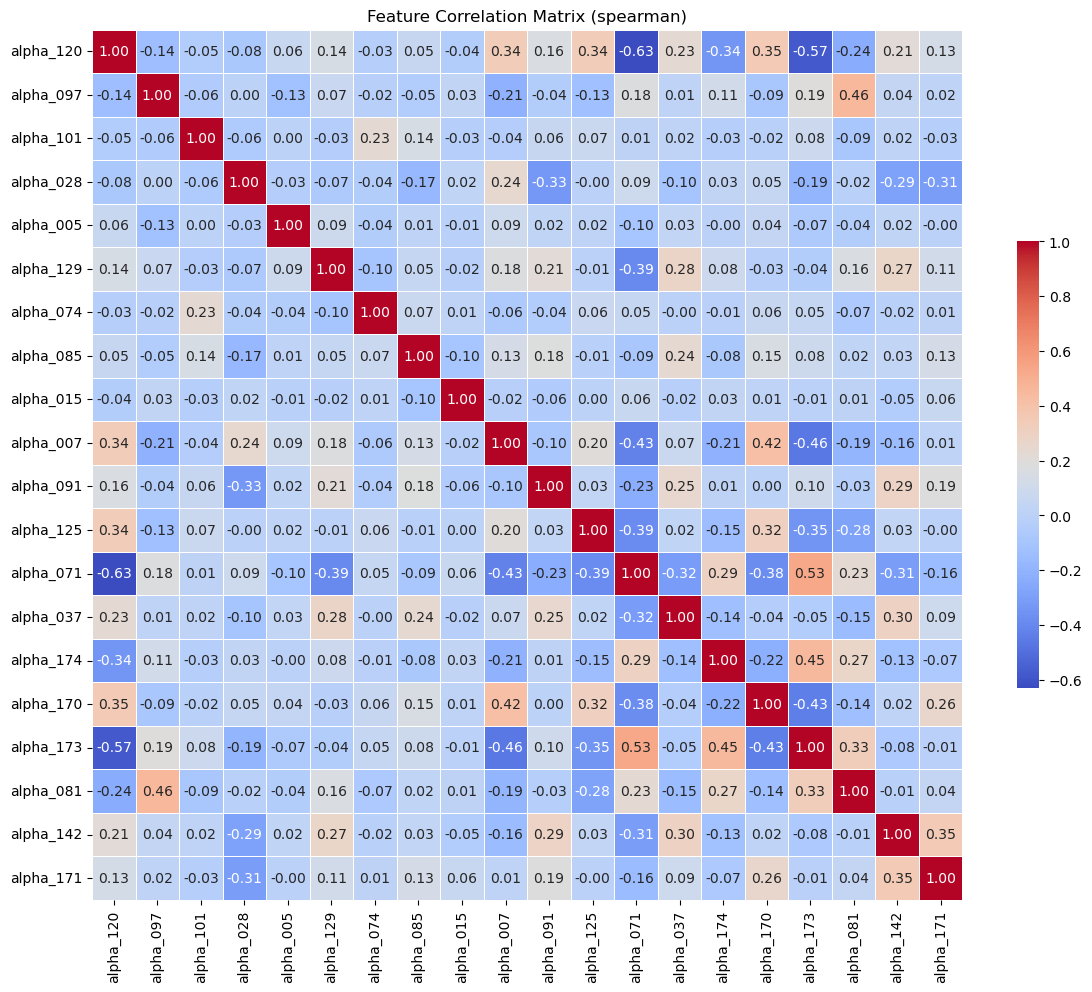

[2025-03-12 14:36:21 - INFO] Correlation plot completed.
[2025-03-12 14:36:21 - INFO] Factor selection: ['alpha_120', 'alpha_097', 'alpha_101', 'alpha_028', 'alpha_005', 'alpha_129', 'alpha_074', 'alpha_085', 'alpha_015', 'alpha_007', 'alpha_091', 'alpha_125', 'alpha_071', 'alpha_037', 'alpha_174', 'alpha_170', 'alpha_173', 'alpha_081', 'alpha_142', 'alpha_171']


In [36]:
# 3 特征选择
X,y = Load_X_y().transform(factors.fillna(0),exc_returns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
features = seq.select_features(LGBMFeatureSelector(model_type='reg',n=20), X_train.fillna(0), y_train)

In [37]:
# 4 模型训练
model = seq.train_model(LGBMRollingRegressor, features, y_train)

[2025-03-12 14:36:33 - INFO] # 4. Training model
[2025-03-12 14:36:33 - INFO] Starting optimization with study name: EXP_ENH300_1M_9c9bee22
[I 2025-03-12 14:36:34,307] A new study created in RDB with name: EXP_ENH300_1M_9c9bee22
[I 2025-03-12 14:36:35,826] Trial 0 finished with value: 0.1394917400166511 and parameters: {'num_leaves': 25, 'n_estimators': 500, 'learning_rate': 0.012057126287443761, 'max_depth': 5, 'min_child_samples': 40, 'subsample': 0.55, 'colsample_bytree': 0.5, 'max_bin': 500, 'reg_alpha': 0.006358358856676255, 'reg_lambda': 0.013311216080736894, 'cat_smooth': 11, 'path_smooth': 10}. Best is trial 0 with value: 0.1394917400166511.
[I 2025-03-12 14:36:36,709] Trial 1 finished with value: 0.13949675198889966 and parameters: {'num_leaves': 45, 'n_estimators': 150, 'learning_rate': 0.0018559980846490584, 'max_depth': 3, 'min_child_samples': 60, 'subsample': 0.7, 'colsample_bytree': 0.65, 'max_bin': 300, 'reg_alpha': 0.006847920095574782, 'reg_lambda': 0.00026210878782654

best paras: {'num_leaves': 40, 'n_estimators': 400, 'learning_rate': 0.022953495563893447, 'max_depth': 5, 'min_child_samples': 120, 'subsample': 0.75, 'colsample_bytree': 0.8, 'max_bin': 500, 'reg_alpha': 0.0024314584033275338, 'reg_lambda': 0.012334689148484594, 'cat_smooth': 18, 'path_smooth': 3}
best value: 0.13924001532767605


[2025-03-12 14:57:55 - INFO] Model training completed successfully


In [38]:
# 6、模型跟踪
config_data = {
    'codes': features.index.levels[1].unique().tolist(),
    'features': features.columns.tolist(),
}

# local_uri = 'http://192.168.215.3:5115'
remote_uri = 'http://192.168.31.220:5115'

run_id = seq.track_model(
    track_ui=remote_uri,
    exp_name=seq.name,
    model=model,
    params=model.get_params(),
    config=config_data,
)

# 跟新run_id到本地
seq.update_run_ids(model_name=seq.name,run_id=run_id)

[2025-03-12 14:58:03 - INFO] Starting model tracking with MLflow...
[2025-03-12 14:58:03 - INFO] Tracking experiment: EXP_ENH300_1M
[2025-03-12 14:58:03 - INFO] Parameters to track: ['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'cat_smooth', 'path_smooth', 'verbosity']
2025/03/12 14:58:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[2025-03-12 14:58:05 - INFO] Model "EXP_ENH300_1M" successfully tracked in MLflow


MLflow run ID: a9680ec9dfa444ca98770a4143d404f5
🏃 View run wise-moth-827 at: http://192.168.31.220:5115/#/experiments/169827057229069451/runs/a9680ec9dfa444ca98770a4143d404f5
🧪 View experiment at: http://192.168.31.220:5115/#/experiments/169827057229069451


In [19]:

from QHAlphalens import tears,utils
from QHMlflow.mlflowtracker import load_model_and_config

remote_uri = 'http://192.168.31.220:5115'
# 加載模型和配置文件
run_ids = seq.load_run_ids()
model,config_file = load_model_and_config(remote_tracking_uri=remote_uri,run_id=run_ids[seq.name]) 

predictions = pd.Series(index=factors.index, data=model.predict(factors.loc[:, config_file['features']]))

# 2. 价格数据
# 假设 dataset 是一个包含价格数据的 DataFrame，包含 'close' 列
prices = stk_data.loc[stk_data.index,'close'].unstack()  # 将价格数据转换为适合 AlphaLens 的格式

# 3. 计算因子和前向收益
factor_data = utils.get_clean_factor_and_forward_returns(
    quantiles=5,
    factor=predictions,
    prices=stk_data.loc[predictions.index,'close'].unstack(),
    periods=(1,)  # 1天、5天和10天的前向收益
)

# 4. 分析因子表现
# 计算因子表现
# tears = tears.create_full_tear_sheet(factor_data)

AssertionError: Length of new_levels (3) must be <= self.nlevels (2)

In [47]:
# 7 加载模型，更新持仓
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
from datetime import datetime
from skfolio import RiskMeasure
from skfolio.optimization import EqualWeighted
from QHMlflow.mlflowtracker import load_model_and_config

# MLflow配置
remote_uri = 'http://192.168.31.220:5115'
# 加載模型和配置文件
run_ids = seq.load_run_ids()
model,config_file = load_model_and_config(remote_tracking_uri=remote_uri,run_id=run_ids[seq.name]) 


def select_top_stocks(model, factors, top_n=100):
    """选择预测收益排名前top_n的股票
    
    Args:
        model: 训练好的模型
        factors: 因子数据
        top_n: 选择的股票数量
    
    Returns:
        list: 选中的股票代码列表
    """
    last_day = factors.index.get_level_values(0).max()
    pred_data = factors.loc[([last_day, last_day], slice(None)), config_file['features']]
    
    # 计算预测排名
    predictions = pd.DataFrame(
        index=pred_data.index,
        data=model.predict(pred_data),
        columns=['rank']
    )
    ranker = predictions.groupby(level=0, group_keys=False).apply(
        lambda x: x.rank(ascending=True).astype(int)
    )
    
    return ranker.sort_values(by='rank').tail(top_n).index.get_level_values(1).tolist()

def calculate_portfolio_weights(stocks_data, codes, total_capital):
    """计算投资组合权重和交易数量
    
    Args:
        stocks_data: 股票行情数据
        codes: 选中的股票代码列表
        total_capital: 总投资金额
    
    Returns:
        tuple: (权重序列, 交易数量序列)
    """
    # 计算近一年收益率
    returns = (stocks_data.loc[(slice(None), codes),]
              .close.unstack()
              .pct_change()
              .fillna(0)
              .tail(52))
    
    # 划分训练集和测试集
    train_size = int(len(returns) * 0.9)
    returns_train = returns.iloc[:train_size]
    returns_test = returns.iloc[train_size:]
    
    # 计算投资组合权重
    optimizer = EqualWeighted()
    optimizer.fit(returns_train)
    weights = optimizer.predict(returns_test).weights
    
    # 计算交易数量(按手取整)
    last_day = stocks_data.index.get_level_values(0).max()
    last_prices = stocks_data.loc[(last_day, codes), 'close']
    trade_amounts = ((total_capital * weights) / last_prices / 100).astype(int) * 100
    
    return weights, trade_amounts

def save_portfolio(codes, weights, amounts, filename_prefix):
    """保存投资组合到CSV文件
    
    Args:
        codes: 股票代码列表
        weights: 权重序列
        amounts: 交易数量序列
        filename_prefix: 文件名前缀
    """
    portfolio_df = pd.DataFrame({
        '代码': codes,
        '相对权重': np.round(weights, 3),
        '数量': amounts,
        '方向': 0,
        '量比': None
    })
    
    # 保存结果
    date_str = datetime.now().strftime('%y%m%d')
    portfolio_df.to_csv(f'positions/{filename_prefix}_{date_str}.csv', index=False)
    
    return portfolio_df

# 主流程
def main():
    # 1. 选股
    target_codes = select_top_stocks(model, factors, top_n=60)
    
    # 2. 计算权重和数量
    weights, trade_amounts = calculate_portfolio_weights(
        stocks_data=stk_data.dropna(subset=['open','close'], axis=0),
        codes=target_codes,
        total_capital=1000000
    )
    
    # 3. 保存结果
    portfolio_df = save_portfolio(
        codes=trade_amounts.index.get_level_values(1).tolist(),
        weights=weights,
        amounts=trade_amounts.values,
        filename_prefix='中证500指数增强'
    )
    
    # 4. 展示结果
    import duckdb
    duckdb.sql('select * from portfolio_df').show()

if __name__ == "__main__":
    main()

┌─────────┬──────────┬───────┬───────┬───────┐
│  代码   │ 相对权重 │ 数量  │ 方向  │ 量比  │
│ varchar │  double  │ int64 │ int64 │ int32 │
├─────────┼──────────┼───────┼───────┼───────┤
│ 000338  │    0.017 │  1000 │     0 │  NULL │
│ 300418  │    0.017 │   400 │     0 │  NULL │
│ 000301  │    0.017 │  1800 │     0 │  NULL │
│ 600015  │    0.017 │  2300 │     0 │  NULL │
│ 600016  │    0.017 │  4000 │     0 │  NULL │
│ 601111  │    0.017 │  2300 │     0 │  NULL │
│ 688303  │    0.017 │   700 │     0 │  NULL │
│ 300450  │    0.017 │   700 │     0 │  NULL │
│ 600732  │    0.017 │  1200 │     0 │  NULL │
│ 601360  │    0.017 │  1500 │     0 │  NULL │
│   ·     │      ·   │    ·  │     · │    ·  │
│   ·     │      ·   │    ·  │     · │    ·  │
│   ·     │      ·   │    ·  │     · │    ·  │
│ 000002  │    0.017 │  2100 │     0 │  NULL │
│ 601328  │    0.017 │  2300 │     0 │  NULL │
│ 300347  │    0.017 │   200 │     0 │  NULL │
│ 300496  │    0.017 │   200 │     0 │  NULL │
│ 002812  │    0.017 │   

In [43]:
pred_data = factors.loc[:, config_file['features']]

# # 计算预测排名
predictions = pd.DataFrame(
    index=pred_data.index,
    data=model.predict(pred_data),
)


# ranker = predictions.groupby(level=0, group_keys=False).apply(
#     lambda x: x.rank(ascending=True).astype(int)
#     )

<Axes: xlabel='date'>

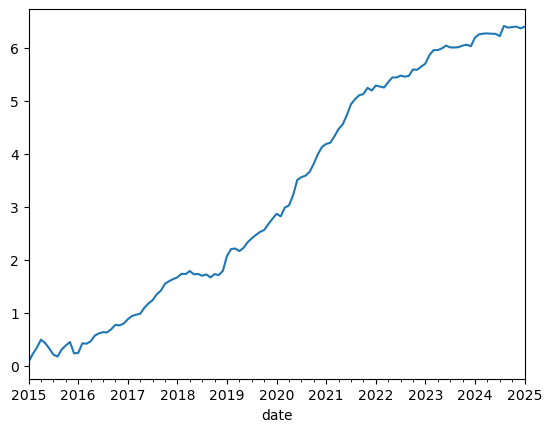

In [46]:
returns = pd.DataFrame(data = stk_data.close.unstack().pct_change().shift(-1).stack(),columns=['returns'])
# returns.columns.name = 'returns'
df = pd.merge(returns,predictions,on=['date','code'])

df = df.groupby('date').apply(lambda x: x.nlargest(60, 0)).reset_index(level=0, drop=True)
df.groupby(level=0).apply(lambda x:x['returns'].mean()).cumsum().plot()


In [ ]:
from QHUtil.plotter import StrategyPlotter

StrategyPlotter(returns=).plot_strategy_summary()